In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import os
from faces_clustering import get_files_folder, VideoClustering, is_image

Using TensorFlow backend.


In [2]:
video_path = "C:/Users/paulo/Documents/videos360/vlog_gelo.mp4"

In [3]:
dir_path = video_path.split('.')[0]
dir_path

'C:/Users/paulo/Documents/videos360/vlog_gelo'

## Extracting Frames

In [ ]:
cap=cv2.VideoCapture(video_path)
fps = int(round(cap.get(cv2.CAP_PROP_FPS)))

if os.path.isdir(dir_path):
    os.rmdir(dir_path)
os.mkdir(dir_path)

In [ ]:
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i%fps == 0:
        cv2.imwrite(f'{dir_path}/frame_{i}.jpg',frame)
    i+=1

## Extracting Viewports

In [4]:
from faces_clustering import Equirec2Perspec as E2P
from mtcnn import MTCNN

In [5]:
import cv2
import numpy as np

In [6]:
def detect_faces(pixels_rgb):
    
    detector = MTCNN()
    results = detector.detect_faces(pixels_rgb)
    
    faces = []
    bounds = []
    for result in results:
        if result['confidence'] >= 0.7:
            x1, y1, width, height = result['box']
            x2, y2 = x1 + width, y1 + height
            x1 = max(x1,0)
            y1 = max(y1,0)
            face = pixels_rgb[y1:y2, x1:x2]

            if face.shape[0] > 0 and face.shape[1] > 0:
                faces.append(face)
                bounds.append((x1,x2,y1,y2))

                pixels_rgb = cv2.rectangle(pixels_rgb, (x1,y1), (x2,y2), (255,0,0), 5)
    return pixels_rgb, bounds

In [7]:
frames = get_files_folder(dir_path, is_image)
frames

['C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1008.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1032.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1056.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1080.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1104.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1128.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1152.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1176.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_120.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1200.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1224.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1248.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1272.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1296.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1320.jpg',
 'C:/Users/paulo/Documents

In [182]:
#equ = E2P.Equirectangular('C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_4272.jpg')
equ = E2P.Equirectangular('C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_7464.jpg')
#equ = E2P.Equirectangular("C:/Users/paulo/Pictures/equ_earth.png")

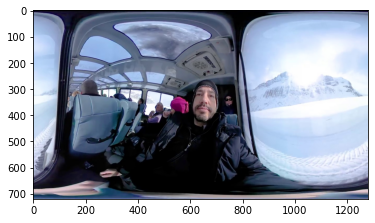

In [183]:
plt.imshow(equ._img[:,:,::-1])

In [184]:
def deg_coord(x, y, lat, long, fovw, fovh, width): 
    height = width*fovh/fovw
    
    max_w = np.sin(np.radians(fovw/2))
    min_w = -max_w

    max_h = np.sin(np.radians(fovh/2))
    min_h = -max_h
    
    x_w = x/width
    x_sin = (x_w*(max_w-min_w))+min_w

    y_h = y/height
    y_sin = (y_h*(max_h-min_h))+min_h

    x_deg = long+np.degrees(np.arcsin(x_sin))
    y_deg = lat-np.degrees(np.arcsin(y_sin))
    return x_deg, y_deg

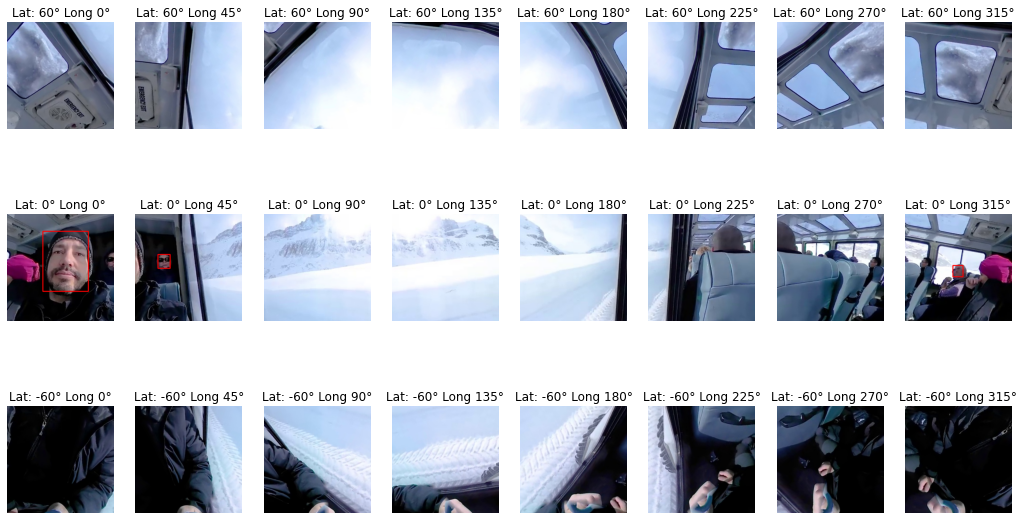

In [185]:
all_bounds = []
eq_bounds = []
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(18, 10))
fovw = 60
fovh = 60
width = 720


for i in range(3):
    for j in range(8):
        lat = i*(-60)+60
        long = 45*j
        img = equ.GetPerspective(fovw, fovh, long, lat, width)    
        img, bounds = detect_faces(np.uint16(img[:,:,::-1])) #x1,x2,y1,y2       
        
        for bound in bounds:
            x1, x2, y1, y2 = bound
            
            eq_x1, eq_y1 = deg_coord(x1, y1, lat, long, fovw, fovh, width)
            eq_x2, eq_y2 = deg_coord(x2, y2, lat, long, fovw, fovh, width)      
            
            eq_bounds = eq_bounds+[(eq_x1, eq_x2, eq_y1, eq_y2)]
            
        all_bounds = all_bounds+bounds

        axes[i,j].set_title(f'Lat: {lat}° Long {long}°')
        axes[i,j].imshow(img)
        axes[i,j].axis('off')
plt.show()

In [186]:
eq_bounds

[(-9.513371519401353,
  15.053580438002395,
  19.809193636742553,
  -12.839588406904147),
 (28.37472351747483,
  35.08295104298162,
  7.020370749121086,
  -0.3978905558392429),
 (311.9746504557745,
  317.38801546326874,
  1.1141548169666693,
  -4.93992113216305)]

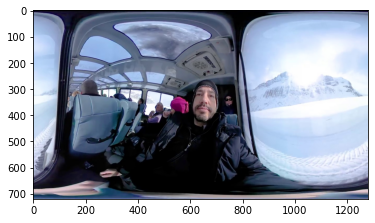

602 691 286 413


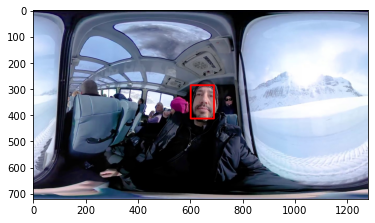

737 762 334 365


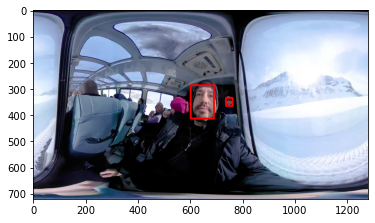

460 482 358 381


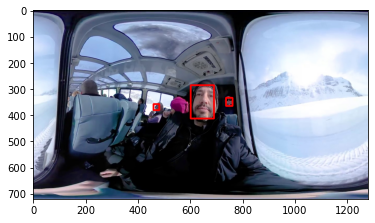

In [187]:
eq_img = np.uint16(equ._img[:,:,::-1])
plt.imshow(eq_img)
plt.show()
eq_img.shape

for eq_bound in eq_bounds:
    x1,x2,y1,y2 = eq_bound
    
    width = eq_img.shape[1]
    height = eq_img.shape[0]
    
    # middle long is actualy 90,180
    x1 = np.int(x1+180)%361
    x2 = np.int(x2+180)%361    
    y1 = np.int(y1+90)%181
    y2 = np.int(y2+90)%181
    
    # positioning proportionally    
    x1 = np.int((x1/361)*width)
    x2 = np.int((x2/361)*width)    
    y1 = np.int((1-y1/181)*height)
    y2 = np.int((1-y2/181)*height)
    
    eq_img = cv2.rectangle(eq_img, (x1,y1), (x2,y2), (255,0,0), 5)
    print(x1,x2,y1,y2)
    plt.imshow(eq_img)
    plt.show()